# Usage of the GWLLoader library to calculate Global Warming Levels
This example demonstrates how to use the GWLLoader python library to calculate global warming levels. 
It will first calculate global warming levels - using `freva` and `intake` - for a single model. The 2nd example will offer a simple recipe to calculate global warming levels for multiple models.

In [1]:
import os
os.environ["EVALUATION_SYSTEM_CONFIG_FILE"] = "/work/ch1187/freva-dev/freva/evaluation_system.conf"
from gwl_loader import GWLLoader

Let's calculate the global warming level of the `ssp370` experiment in the `cmip6` project. The model will be the `MPI-ESM1-2-HR` model. 

In [2]:
# Model name and experiment must be defined
model = "MPI-ESM1-2-HR"
experiment = "ssp370"
# Additional search facets should be set to refine the search
search_facets = dict(project="cmip6", ensemble="r1i1p1f1")

First we are going to calculate the warming levels using the free evaluation system framework (freva). 

In [3]:
gwl = GWLLoader.load_data_with_freva(model, experiment=experiment, **search_facets)

The calculated data can be inspected using the `data_array` or `data_frame` properties. The `data_array` property will return an `xarray.DataArray` instance representing the 30 year rolling mean of the global averaged dataset. The `data_frame` property returns a `pandas.DataFrame` representation of the data.

In [4]:
gwl.data_array

<xarray.DataArray 'tas' (model: 1, year: 222)>
dask.array<add, shape=(1, 222), dtype=float64, chunksize=(1, 31), chunktype=numpy.ndarray>
Coordinates:
  * model    (model) <U13 'MPI-ESM1-2-HR'
  * year     (year) int64 1865 1866 1867 1868 1869 ... 2082 2083 2084 2085 2086
    height   float64 2.0
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP AerChemMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-mpi-esm@dkrz.de
    creation_date:          2019-07-20T13:41:51Z
    data_specs_version:     01.00.30
    experiment:             gap-filling scenario reaching 7.0 based on SSP3
    experiment_id:          ssp370
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.DKRZ.MPI-ESM...
    grid:                   gn
    grid_label:             gn
    history:                2019-07-20T13:41:51Z altered by CMOR: Treated sca...
    initialization_index:   1
    institution:            Deutsches Klimarechenzentrum, Hamburg 20146, Germany
    institution_id:         DKRZ
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       MPI-ESM1-2-HR
    parent_time_units:      days since 1850-1-1 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    project_id:             CMIP6
    realization_index:      1
    realm:                  atmos
    references:             MPI-ESM: Mauritsen, T. et al. (2019), Development...
    source:                 MPI-ESM1.2-HR (2017): \naerosol: none, prescribed...
    source_id:              MPI-ESM1-2-HR
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    table_info:             Creation Date:(09 May 2019) MD5:e6ef8ececc8f33864...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by DKRZ is licensed und...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/d6f0f6b2-b4c2-460b-bc5e-f1c72f932399
    standard_name:          air_temperature
    long_name:              Near-Surface Air Temperature
    comment:                near-surface (usually, 2 meter) air temperature
    units:                  K
    cell_methods:           area: time: mean
    cell_measures:          area: areacella

In [5]:
gwl.data_frame

MPI-ESM1-2-HR
year               
1865       0.011893
1866       0.012460
1867       0.014830
1868       0.009464
1869       0.004824
...             ...
2082       3.042443
2083       3.073232
2084       3.104515
2085       3.138146
2086       3.176560

[222 rows x 1 columns]

Which means that we can easily plot the data.

<AxesSubplot:xlabel='year'>

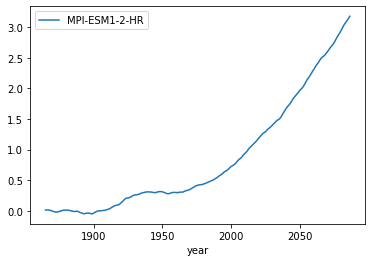

In [6]:
gwl.data_frame.plot()

The first and last year of the window  when a specific global warming level is reached can be rettreived by the `.get_global_warming_year` method

In [8]:
gwl.get_global_warming_year(2.4)

(2048, 2078)

### Comparison of `freva` and `intake`
We can also use intake catalogues to search and open the data if freva is not available. Let's apply a performance test to find out which systems are faster:

In [9]:
%%timeit
gwl_intake = GWLLoader.load_data_with_intake(model, experiment=experiment, **search_facets)

1min 11s ± 844 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
gwl_freva = GWLLoader.load_data_with_freva(model, experiment=experiment, **search_facets)

27.1 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Recipe: Multiple Models

This example shows a simple recipe using `dask.delayed` functionality to efficiently process multiple models at once. The strategy is writing a `delayed` function that processes each model one by one.

In [11]:
import pandas as pd
import dask
from matplotlib import pyplot as plt

@dask.delayed
def load_gwl(model: str, experiment: str, **search_facets) -> pd.DataFrame:
    gwl = GWLLoader.load_data_with_freva(model, experiment=experiment, **search_facets)
    return gwl.data_frame

models = "mpi-esm1-2-hr", "access-esm1-5", "ec-earth3", "canesm5", "noresm2-mm"

results = dask.compute(*[load_gwl(m, experiment, **search_facets) for m in models])
data_frame = pd.concat(results, axis=1)
data_frame

mpi-esm1-2-hr  access-esm1-5  ec-earth3   canesm5  noresm2-mm
year                                                               
1865       0.011893       0.387738   0.479916 -0.025410    0.459757
1866       0.012460       0.384203   0.485835 -0.024170    0.455169
1867       0.014830       0.381839   0.491561 -0.014892    0.460266
1868       0.009464       0.382915   0.490781 -0.011559    0.464620
1869       0.004824       0.385535   0.498938 -0.007953    0.459075
...             ...            ...        ...       ...         ...
2082       3.042443       3.909513   4.340161  5.325007    3.059525
2083       3.073232       3.952329   4.397576  5.380109    3.088666
2084       3.104515       3.997302   4.457868  5.436804    3.125371
2085       3.138146       4.043986   4.499581  5.498836    3.169176
2086       3.176560       4.093592   4.543625  5.560690    3.212976

[222 rows x 5 columns]

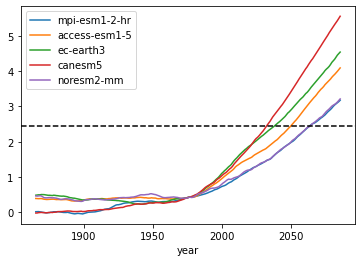

In [12]:
fig, ax = plt.subplots(1,1)
data_frame.plot(ax=ax)
_ = ax.axhline(y=2.45, linestyle='--', color='k')